In [2]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from ipywidgets import FloatProgress
from IPython.display import display

import torch
print(torch.__version__)

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 12})

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

1.0.1


## Prioritized Replay Buffer ++

In [65]:
class PrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.states_count = {0:0, 1:0, 'frac': 0}
        self.states_loss = {0:0, 1:0, 'frac': 0}
    
    def push(self, meta_state, action, reward, meta_next_state, done):
        state = meta_state[0] 
        state_env = meta_state[1] 
        next_state = meta_next_state[0]
        
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done, int(state_env)))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done, int(state_env))
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        batch       = list(zip(*samples))
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        state_envs = list(batch[5])
        
        # increment states count
        self.states_count[0] += len(state_envs) - sum(state_envs) # states.shape[0] - np.sum(states[:,-1])
        self.states_count[1] += sum(state_envs)  # np.sum(states[:,-1])
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

In [66]:
beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

## Cartpole Env

In [67]:
env_id = "CartPole-v0"
env = gym.make(env_id)
val_env = gym.make(env_id)
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

## DQN

In [68]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )
        self.fc = nn.Linear(128, env.action_space.n)
        
    def forward(self, x):
        out = self.layers(x)
        out = self.fc(F.relu(out))
        return out
    
    def get_hidden(self, x):
        hidden = self.layers(x)
        return hidden
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
            action = int(action)
        else:
            action = random.randrange(env.action_space.n)
        return action

In [69]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters())

In [70]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [71]:
update_target(current_model, target_model)

## TD Loss

In [72]:
def compute_td_loss(cur_model, tar_model, batch_size, beta):
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)
    
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    weights    = Variable(torch.FloatTensor(weights))

    q_values      = cur_model(state)
    next_q_values = tar_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss  = (q_value - expected_q_value.detach()).pow(2) * weights
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()
    
    return loss

## Plot

In [73]:
def plot(frame_idx, rewards, losses, standard_val_rewards, noisy_val_rewards, states_count_ratios):
    clear_output(True)
    plt.figure(figsize=(20,16))
    plt.subplot(321)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(322)
    plt.title('loss')
    plt.plot(losses)
    plt.subplot(323)
    plt.title('frame %s. val reward on standard env: %s' % (frame_idx, np.mean(standard_val_rewards[-10:])))
    plt.plot(standard_val_rewards)
    plt.subplot(324)
    plt.title('frame %s.val reward on noisy env: %s' % (frame_idx, np.mean(noisy_val_rewards[-10:])))
    plt.plot(noisy_val_rewards)
    plt.subplot(325)
    plt.title('frame %s. proportion of selecting noisy env: %s' % (frame_idx, np.mean(states_count_ratios[-10:])))
    plt.plot(states_count_ratios)
    plt.show()

## Train

In [78]:
# Test agent on standard or noisy env
# Resulting episode reward stored in XXX_val_rewards where XXX is standard or noisy 
num_val_trials = 10
def test(noisyGame, eps):
    rewards = []
    for i in range(num_val_trials):
        epsilon = 0 
        episode_reward = 0
        state = val_env.reset()
        state = np.append(state, float(noisyGame)) # BACK IN 
        with torch.no_grad():
            while True:
                original_action = current_model.act(state, epsilon)
                
                if original_action != int(original_action):
                    original_action = original_action.numpy()[0]

                if noisyGame and random.uniform(0,1) < eps:
                    actual_action = 1 - original_action
                else:
                    actual_action = original_action 

                next_state, reward, done, _ = val_env.step(actual_action)
                next_state = np.append(next_state, float(noisyGame))
                
                if noisyGame:
                    reward += random.uniform(-1., 1.)
                
                state = next_state
                episode_reward += reward

                if done:
                    rewards.append(episode_reward)
                    break 
    return np.mean(rewards)

In [81]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
standard_val_rewards = [] 
noisy_val_rewards = [] 
states_count_ratios = []
episode_reward = 0

noisyGame = False
state = env.reset()
state = np.append(state, float(noisyGame)) # BACK IN 
meta_state = (state, float(noisyGame))
# zerod_state = np.append(state[:-1] ,0) #np.append(state, 0)
replay_buffer = PrioritizedBuffer(100000)
current_model = DQN(env.observation_space.shape[0] + 1, env.action_space.n) # BACK IN 
target_model  = DQN(env.observation_space.shape[0] + 1, env.action_space.n) # BACK IN
optimizer = optim.Adam(current_model.parameters())

# Probability of action being random in noisy state
eps = 1.
f = FloatProgress(min=0, max=num_frames)
display(f)

for frame_idx in range(1, num_frames + 1):
    # env.env.viewer.window.dispatch_events()
    epsilon = epsilon_by_frame(frame_idx)
    original_action = current_model.act(state, epsilon)
    
    # If in noisy environment, make action random with probability eps 
    if noisyGame and random.uniform(0,1) < eps:
        actual_action = original_action # invert 
    else:
        actual_action = original_action
    next_state, reward, done, _ = env.step(actual_action)
    
    # If in noisy environment, make reward completely random 
    if noisyGame:
        reward *= random.uniform(-1., 1.)
    next_state = np.append(next_state, float(noisyGame)) # BACK IN 
    meta_next_state = (next_state, float(noisyGame))
    #zerod_state = np.append(next_state[:-1], 0)
    #replay_buffer.push(state, original_action, reward, next_state, done)
    replay_buffer.push(meta_state, original_action, reward, meta_next_state, done)

    meta_state = meta_next_state
    episode_reward += reward
    
    if done:
        noisyGame = 1-noisyGame
        state = env.reset()
        state = np.append(state, float(noisyGame)) # BACK IN 
        meta_state = (state, float(noisyGame))
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss(current_model, target_model, batch_size, beta)
        losses.append(loss.data.tolist())
        
    if frame_idx % 200 == 0:
        standard_val_rewards.append(test(False, eps))
        noisy_val_rewards.append(test(True, eps))
        states_count_ratios.append(float(replay_buffer.states_count[1]) / (float(replay_buffer.states_count[1])  + float(replay_buffer.states_count[0])))
#         plot(frame_idx, all_rewards, losses, standard_val_rewards, noisy_val_rewards, states_count_ratios)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)
        
    f.value += 1
        
print("prop of selecting noisy env", str(float(replay_buffer.states_count[1]) / (float(replay_buffer.states_count[1])  + float(replay_buffer.states_count[0]))))

/Users/megumisano/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


prop of selecting noisy env 0.7979565860754414


In [ ]:
# flipping control isn't necessary 
# including noisyGame in state is necessary 

In [ ]:
# New environment 

In [86]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch # 

In [107]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)
val_env    = make_atari(env_id)
val_env    = wrap_deepmind(val_env)
val_env    = wrap_pytorch(val_env)

In [88]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
#     def get_hidden(self, x):
#         hidden = self.layers(x)
#         return hidden
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [89]:
current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 10000
replay_buffer  = PrioritizedBuffer(100000)

update_target(current_model, target_model)

In [90]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

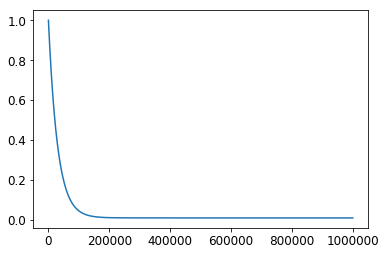

In [91]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

In [111]:
# Test agent on standard or noisy env
# Resulting episode reward stored in XXX_val_rewards where XXX is standard or noisy 
num_val_trials = 10
def test(noisyGame, eps):
    rewards = []
    for i in range(num_val_trials):
        epsilon = 0 
        episode_reward = 0
        state = val_env.reset()
        state[:,:,-1] = float(noisyGame)
        with torch.no_grad():
            while True:
                original_action = current_model.act(state, epsilon)
                
                if original_action != int(original_action):
                    original_action = original_action.numpy()[0]

                if noisyGame and random.uniform(0,1) < eps:
                    actual_action = 1 - original_action
                else:
                    actual_action = original_action 

                next_state, reward, done, _ = val_env.step(actual_action)
                next_state[:,:,-1] = float(noisyGame)
                
                if noisyGame:
                    reward += random.uniform(-1., 1.)
                #next_state = np.append(next_state, float(noisyGame))
                state = next_state
                episode_reward += reward

                if done:
                    rewards.append(episode_reward)
                    break 
    return np.mean(rewards)

In [112]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
standard_val_rewards = [] 
noisy_val_rewards = [] 
states_count_ratios = []
episode_reward = 0

noisyGame = False
state = env.reset()
print("state", state.shape)
state[:,:,-1] = float(noisyGame)
meta_state = (state, float(noisyGame))
replay_buffer = PrioritizedBuffer(100000)
current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)
optimizer = optim.Adam(current_model.parameters())

# Probability of action being random in noisy state
eps = 1.
f = FloatProgress(min=0, max=num_frames)
display(f)

for frame_idx in range(1, num_frames + 1):
    # env.env.viewer.window.dispatch_events()
    epsilon = epsilon_by_frame(frame_idx)
#     original_action = current_model.act(state, epsilon)
    original_action = current_model.act(state, epsilon)
    
    # If in noisy environment, make action random with probability eps 
    if noisyGame and random.uniform(0,1) < eps:
        actual_action = original_action # invert 
    else:
        actual_action = original_action
    next_state, reward, done, _ = env.step(actual_action)
    next_state[:,:,-1] = float(noisyGame)
    next_meta_state = (next_state, noisyGame)
    # If in noisy environment, make reward completely random 
    if noisyGame:
        reward *= random.uniform(-1., 1.)
    #next_state = np.append(next_state, float(noisyGame))
    #zerod_state = np.append(next_state[:-1], 0)
    #replay_buffer.push(state, original_action, reward, next_state, done)
    replay_buffer.push(meta_state, original_action, reward, next_meta_state, done)

    meta_state = next_meta_state 
    episode_reward += reward
    
    if done:
        noisyGame = 1-noisyGame
        state = env.reset()
        state[:,:,-1] = float(noisyGame)
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss(current_model, target_model, batch_size, beta)
        losses.append(loss.data.tolist())
        
    if frame_idx % 200 == 0:
        standard_val_rewards.append(test(False, eps))
        noisy_val_rewards.append(test(True, eps))
        states_count_ratios.append(float(replay_buffer.states_count[1]) / (float(replay_buffer.states_count[1])  + float(replay_buffer.states_count[0])))
#         plot(frame_idx, all_rewards, losses, standard_val_rewards, noisy_val_rewards, states_count_ratios)
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)
        
    f.value += 1
        
print("prop of selecting noisy env", str(float(replay_buffer.states_count[1]) / (float(replay_buffer.states_count[1])  + float(replay_buffer.states_count[0]))))

state (1, 84, 84)


/Users/megumisano/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


prop of selecting noisy env 0.3614942817014446


In [95]:
env.observation_space.shape

(1, 84, 84)

In [105]:
state[-1,-1,-1] = 1